<a href="https://colab.research.google.com/github/Ashu-00/NLP-Implementations/blob/main/XAI/Captum_on_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install captum

# Single Token Generation and Weighing

In [ ]:
import torch
from captum.attr import IntegratedGradients
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
input_text = "I am just a little sick today. Maybe due to a bad"
tokenized_text = tokenizer(input_text, return_tensors="pt")

input_ids = tokenized_text["input_ids"]
print(input_ids.shape)

torch.Size([1, 13])


In [ ]:
generated_ids = model.generate(input_ids ,  max_length = input_ids.shape[-1]+1) # generate 1 token
generated_token_id = generated_ids[0,-1]
print(tokenizer.decode(generated_token_id))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 cold


In [ ]:
# defining baseline and embeddings

embed_layer = model.get_input_embeddings()
embeds = embed_layer(input_ids)
print(embeds.shape)

baseline_embeds = torch.zeros_like(current_embeds)
print(baseline_embeds.shape)

torch.Size([1, 13, 768])
torch.Size([1, 13, 768])


In [ ]:
def model_forward(input_embeds):
  out = model(inputs_embeds  = input_embeds)
  logits = out.logits
  return logits[0, -1, generated_token_id] .unsqueeze(0)

In [ ]:
int_grads = IntegratedGradients(model_forward)
attr, delta = int_grads.attribute(
    embeds,
    baselines = baseline_embeds,
    n_steps = 50,
    return_convergence_delta=True,
)

In [ ]:
attr.shape

torch.Size([1, 13, 768])

In [ ]:
# Sum attributions across the embedding dimension
token_attributions = attr.sum(dim=-1).squeeze(0)

# Convert input IDs to tokens for visualization
input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Print token attributions
for token, attr in zip(input_tokens, token_attributions):
    print(f"{token}: {attr.item():.4f}")

I: 0.0034
Ġam: 0.0001
Ġjust: 0.0012
Ġa: 0.0014
Ġlittle: -0.0003
Ġsick: -0.0010
Ġtoday: -0.0021
.: -0.0008
ĠMaybe: -0.0018
Ġdue: -0.0015
Ġto: 0.0001
Ġa: 0.0011
Ġbad: -0.0034


In [ ]:
# With increase n_steps
attr, delta = int_grads.attribute(
    embeds,
    baselines = baseline_embeds,
    n_steps = 100,
    return_convergence_delta=True,
)

token_attributions = attr.sum(dim=-1).squeeze(0)

input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

for token, attr in zip(input_tokens, token_attributions):
    print(f"{token}: {attr.item():.4f}")


I: 0.0009
Ġam: 0.0000
Ġjust: 0.0003
Ġa: 0.0004
Ġlittle: -0.0001
Ġsick: -0.0002
Ġtoday: -0.0005
.: -0.0002
ĠMaybe: -0.0004
Ġdue: -0.0004
Ġto: 0.0000
Ġa: 0.0003
Ġbad: -0.0009


# Multiple token generation and weighing

In [ ]:
input_text = "I am a little sick today. Maybe due to a bad"
tokenized_text = tokenizer(input_text, return_tensors="pt")

input_ids = tokenized_text["input_ids"]
print(input_ids.shape)

torch.Size([1, 12])


In [ ]:
num_tokens_to_generate = 20
generated = model.generate(input_ids, max_length=input_ids.shape[-1] + num_tokens_to_generate)
full_sequence = generated[0]
generated_ids = full_sequence[input_ids.shape[-1]:]
print(tokenizer.decode(full_sequence))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a little sick today. Maybe due to a bad cold. I am not sure. I am not sure if I am going to be able to go


In [ ]:
attr_matrix = []
original_length = input_ids.shape[-1]

from tqdm import tqdm
for i in tqdm(range(num_tokens_to_generate)):
    current_pos = original_length + i
    current_input = full_sequence[:current_pos].unsqueeze(0)  # Add batch dim
    target_token_id = full_sequence[current_pos].item()

    current_embeds = embed_layer(current_input)
    baseline_embeds  = torch.zeros_like(current_embeds)

    attributions, delta = int_grads.attribute(
        current_embeds,
        baselines=baseline_embeds,
        n_steps=50,
        return_convergence_delta=True
    )

    token_attributions = attributions.sum(dim=-1).squeeze(0)
    padded_attributions = torch.zeros(len(full_sequence))
    padded_attributions[:current_pos] = token_attributions
    attr_matrix.append(padded_attributions.detach().numpy())



100%|██████████| 20/20 [03:16<00:00,  9.80s/it]


In [ ]:
import numpy as np
attr_matrix = np.array(attr_matrix).T

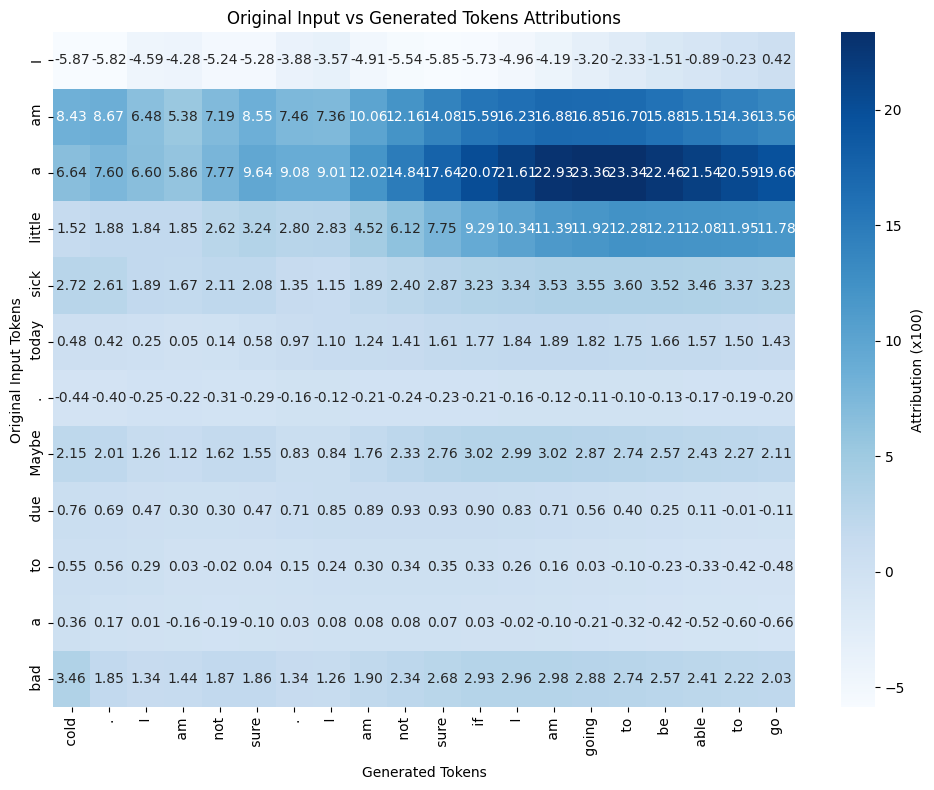

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Slice attributions to original input tokens (ignore generated tokens used as input)
original_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
generated_tokens = tokenizer.convert_ids_to_tokens(generated_ids)

original_tokens = [t.replace("Ġ", " ") for t in original_tokens]
generated_tokens = [t.replace("Ġ", " ") for t in generated_tokens]

# Attributions matrix shape: [original_tokens x generated_tokens]
attributions_matrix = np.array(attr_matrix)[:len(original_tokens), :]

SCALE_FACTOR = 100  # Adjust this to make values more readable
scaled_attributions = attributions_matrix * SCALE_FACTOR

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    scaled_attributions,
    xticklabels=generated_tokens,
    yticklabels=original_tokens,
    annot=True,
    fmt=".2f",  # 2 decimal places
    annot_kws={"fontsize": 10},
    cmap="Blues",
    cbar_kws={'label': f'Attribution (x{SCALE_FACTOR})'}
)
plt.xlabel("Generated Tokens")
plt.ylabel("Original Input Tokens")
plt.title("Original Input vs Generated Tokens Attributions")
plt.tight_layout()
plt.show()

# Further testing

In [ ]:
input_text = "I am not sure if I will be able to"
tokenized_text = tokenizer(input_text, return_tensors="pt")

input_ids = tokenized_text["input_ids"]
print(input_ids.shape)

torch.Size([1, 10])


In [ ]:
num_tokens_to_generate = 10
generated = model.generate(input_ids, max_length=input_ids.shape[-1] + num_tokens_to_generate)
full_sequence = generated[0]
generated_ids = full_sequence[input_ids.shape[-1]:]
print(tokenizer.decode(full_sequence))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am not sure if I will be able to get a job in the next few months, but


In [ ]:
attr_matrix = []
original_length = input_ids.shape[-1]

from tqdm import tqdm
for i in tqdm(range(num_tokens_to_generate)):
    current_pos = original_length + i
    current_input = full_sequence[:current_pos].unsqueeze(0)  # Add batch dim
    target_token_id = full_sequence[current_pos].item()

    current_embeds = embed_layer(current_input)
    baseline_input = torch.full_like(current_input, tokenizer.eos_token_id)
    baseline_embeds = embed_layer(baseline_input)

    attributions, delta = int_grads.attribute(
        current_embeds,
        baselines=baseline_embeds,
        n_steps=50,
        return_convergence_delta=True
    )

    token_attributions = attributions.sum(dim=-1).squeeze(0)
    padded_attributions = torch.zeros(len(full_sequence))
    padded_attributions[:current_pos] = token_attributions
    attr_matrix.append(padded_attributions.detach().numpy())



100%|██████████| 10/10 [01:06<00:00,  6.70s/it]


In [ ]:
import numpy as np
attr_matrix = np.array(attr_matrix).T

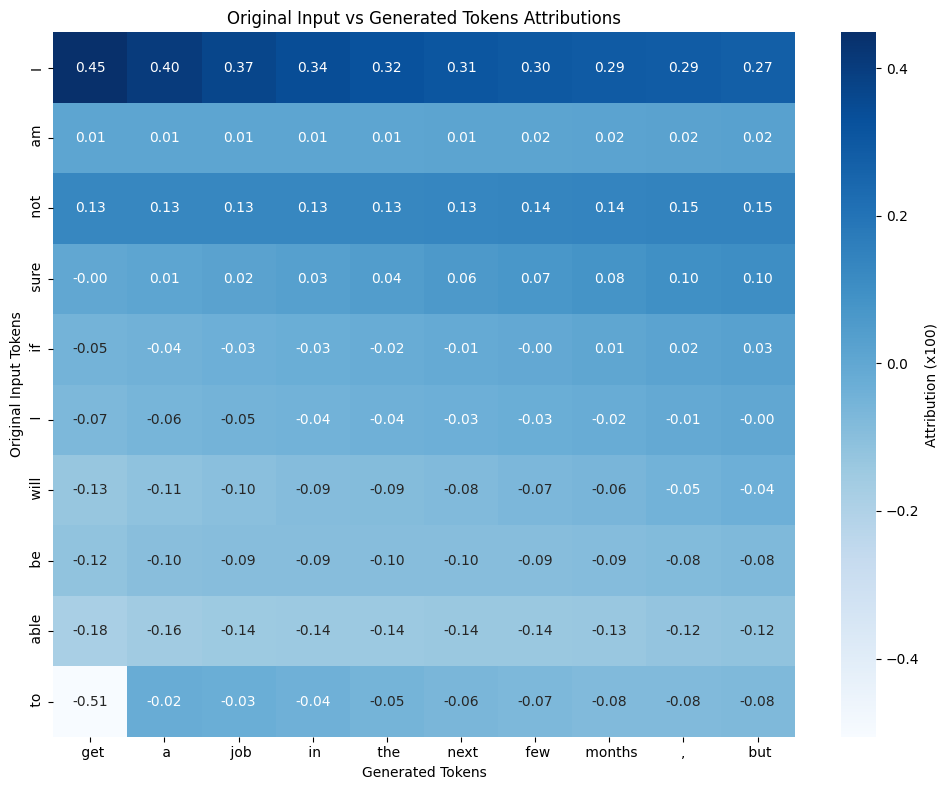

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Slice attributions to original input tokens (ignore generated tokens used as input)
original_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
generated_tokens = tokenizer.convert_ids_to_tokens(generated_ids)

original_tokens = [t.replace("Ġ", " ") for t in original_tokens]
generated_tokens = [t.replace("Ġ", " ") for t in generated_tokens]

# Attributions matrix shape: [original_tokens x generated_tokens]
attributions_matrix = np.array(attr_matrix)[:len(original_tokens), :]

SCALE_FACTOR = 100  # Adjust this to make values more readable
scaled_attributions = attributions_matrix * SCALE_FACTOR

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    scaled_attributions,
    xticklabels=generated_tokens,
    yticklabels=original_tokens,
    annot=True,
    fmt=".2f",  # 2 decimal places
    annot_kws={"fontsize": 10},
    cmap="Blues",
    cbar_kws={'label': f'Attribution (x{SCALE_FACTOR})'}
)
plt.xlabel("Generated Tokens")
plt.ylabel("Original Input Tokens")
plt.title("Original Input vs Generated Tokens Attributions")
plt.tight_layout()
plt.show()

## Function creation for ease of access

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
She opened the door and saw a man in a white shirt and a black hood




100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


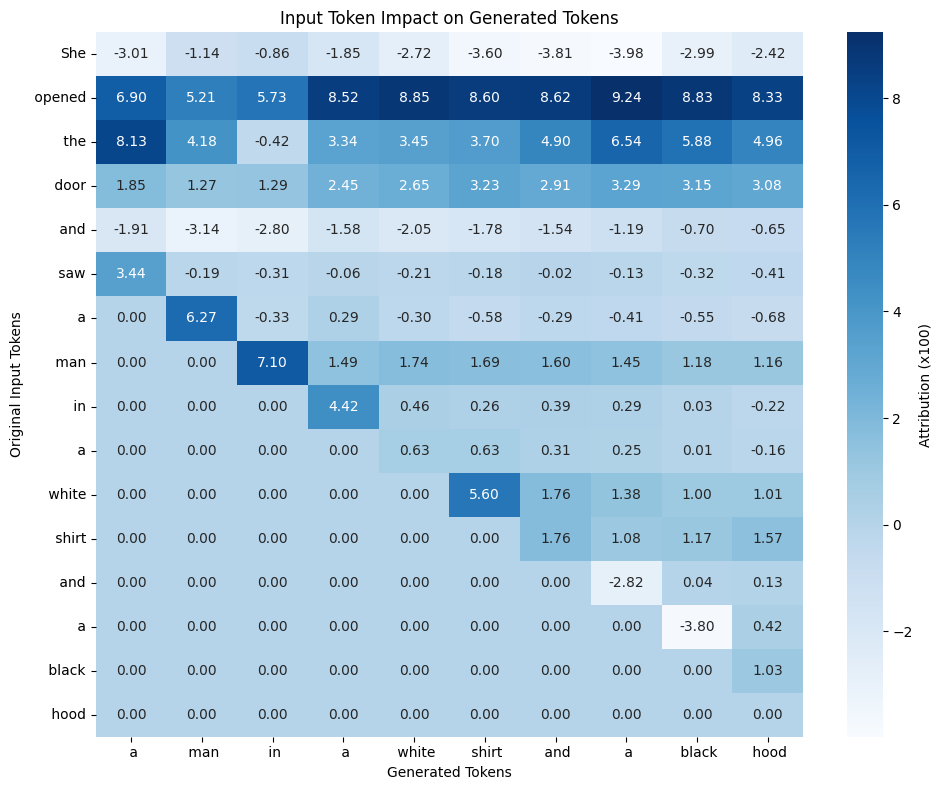

In [ ]:
def generate_and_visualize_attributions(
    input_text,
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
):
    """Generate text with GPT-2 and visualize attribution heatmap between original input and generated tokens."""

    # Load model and tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.eval()

    # Generate text
    inputs = tokenizer(input_text, return_tensors='pt')
    input_ids = inputs['input_ids']
    original_length = input_ids.shape[-1]

    generated = model.generate(
        input_ids,
        max_length=input_ids.shape[-1] + num_tokens_to_generate
    )
    full_sequence = generated[0]
    generated_ids = full_sequence[original_length:]

    # Print generated text
    print("Full generated text:")
    print(tokenizer.decode(full_sequence))
    print("\n")

    # Prepare for attributions
    embed_layer = model.get_input_embeddings()
    attr_matrix = []

    # Compute attributions for each generated token
    for i in tqdm(range(num_tokens_to_generate)):
        current_pos = original_length + i
        current_input = full_sequence[:current_pos].unsqueeze(0)
        target_token_id = full_sequence[current_pos].item()

        # Get embeddings
        current_embeds = embed_layer(current_input)
        baseline_embeds = torch.zeros_like(current_embeds) # change baseline embeddings to zeros

        # Define forward function
        def model_forward(input_embeds):
            return model(inputs_embeds=input_embeds).logits[0, -1, target_token_id].unsqueeze(0)

        # Compute integrated gradients
        int_grads = IntegratedGradients(model_forward)
        attributions = int_grads.attribute(
            current_embeds,
            baselines=baseline_embeds,
            n_steps=n_steps
        )

        # Store attributions
        token_attributions = attributions.sum(dim=-1).squeeze(0)
        padded_attributions = torch.zeros(len(full_sequence))
        padded_attributions[:current_pos] = token_attributions
        attr_matrix.append(padded_attributions.detach().numpy())

    # Process attribution matrix
    attr_matrix = np.array(attr_matrix).T
    original_tokens = [t.replace("Ġ", " ") for t in tokenizer.convert_ids_to_tokens(generated[0])]
    generated_tokens = [t.replace("Ġ", " ") for t in tokenizer.convert_ids_to_tokens(generated_ids)]

    # Create visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attr_matrix * scale_factor, # Changed for all tokens vs generated output
        xticklabels=generated_tokens,
        yticklabels=original_tokens,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        annot_kws={"fontsize": 10},
        cbar_kws={'label': f'Attribution (x{scale_factor})'}
    )
    plt.xlabel("Generated Tokens")
    plt.ylabel("Original Input Tokens")
    plt.title("Input Token Impact on Generated Tokens")
    plt.tight_layout()
    plt.show()

generate_and_visualize_attributions(
    input_text="She opened the door and saw",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
SHe looked at her and said, 'I never thought you would be so kind to me.'

'I




100%|██████████| 10/10 [01:22<00:00,  8.25s/it]


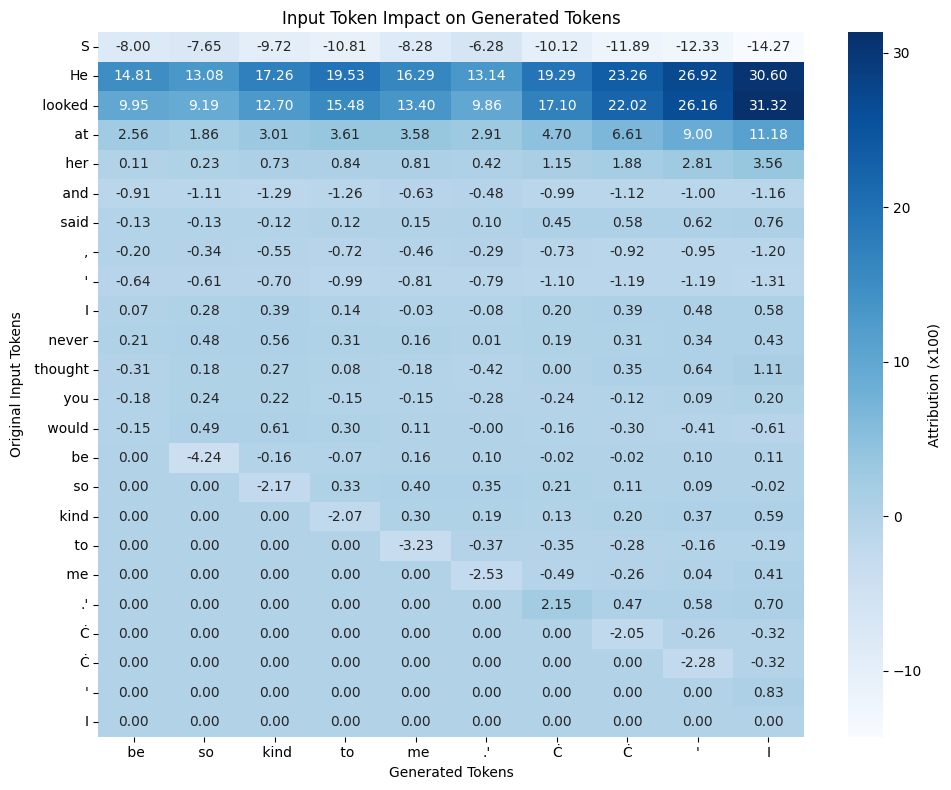

In [ ]:
generate_and_visualize_attributions(
    input_text="SHe looked at her and said, 'I never thought you would",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
The worst part about today was that I was able to get a job in the




100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


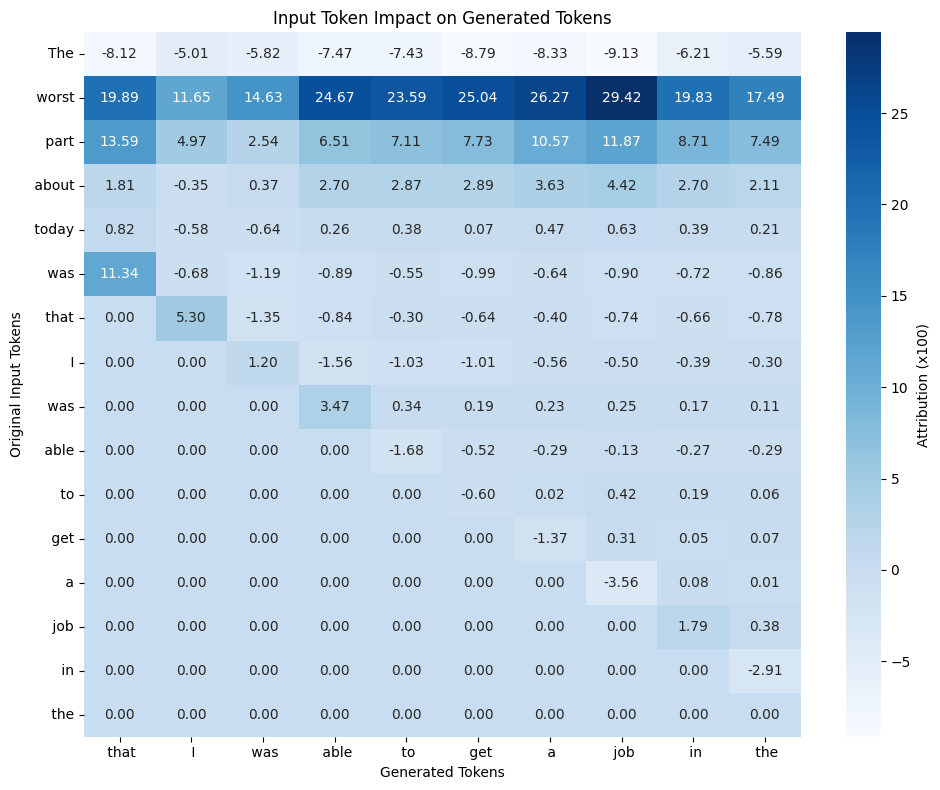

In [ ]:
generate_and_visualize_attributions(
    input_text="The worst part about today was",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
The capital of France is the capital




100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


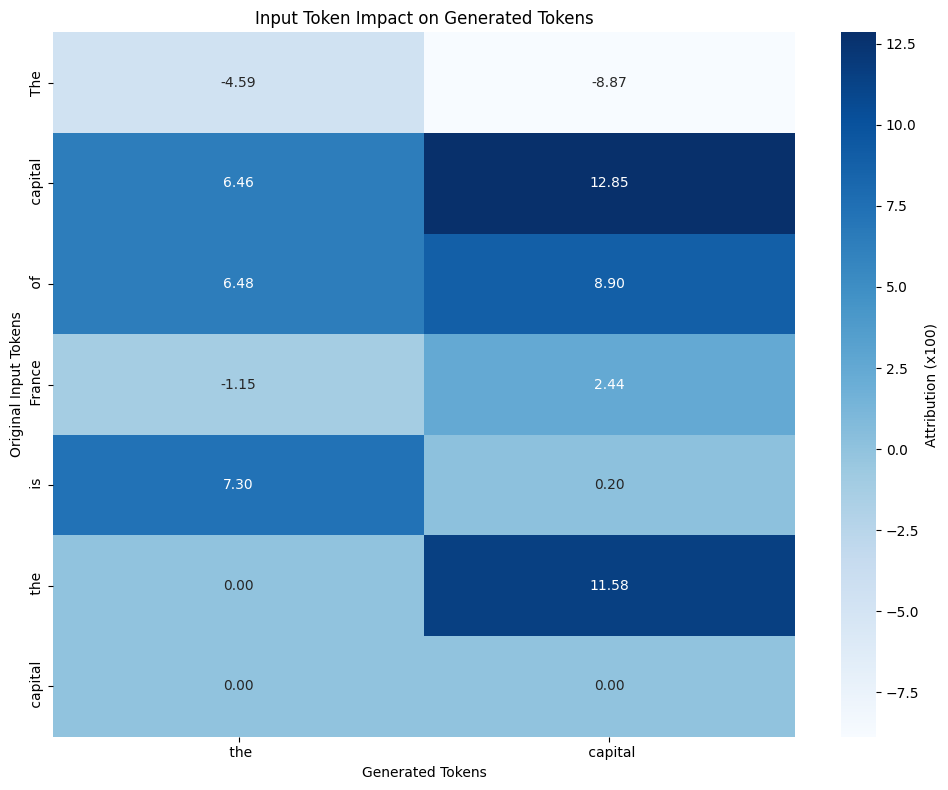

In [ ]:
generate_and_visualize_attributions(
    input_text="The capital of France is",
    num_tokens_to_generate=2,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
TThe best country to live in is the United States.

The United States is




100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


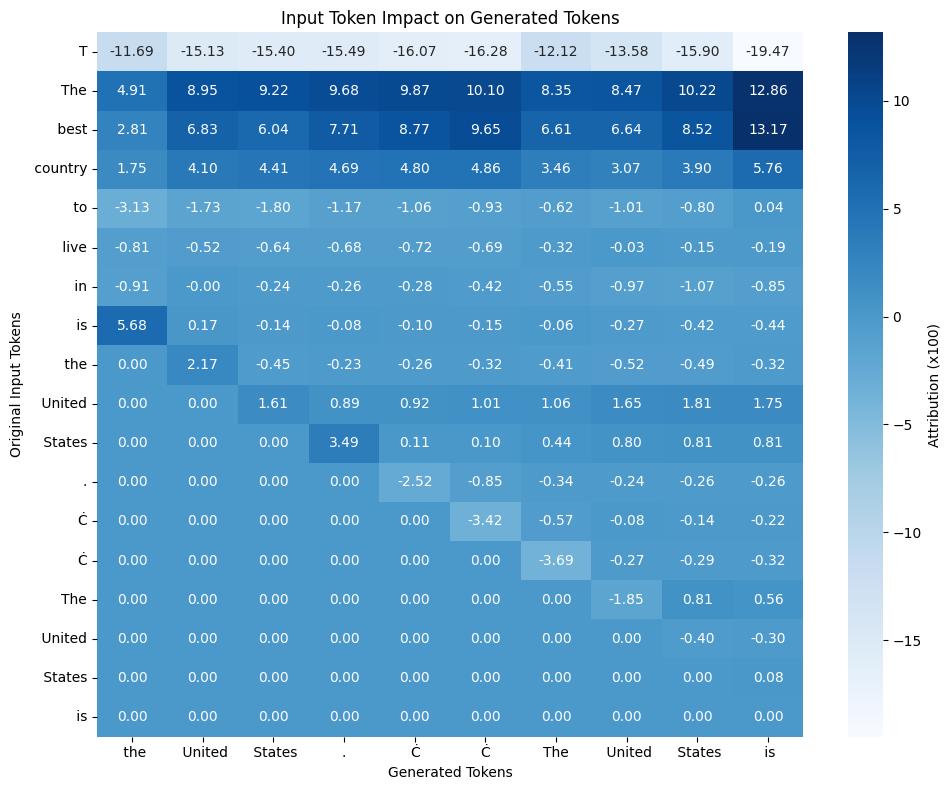

In [ ]:
generate_and_visualize_attributions(
    input_text="TThe best country to live in is",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
In Indian culture, Diwali is celebrated as a day of fasting, a day of fasting for




100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


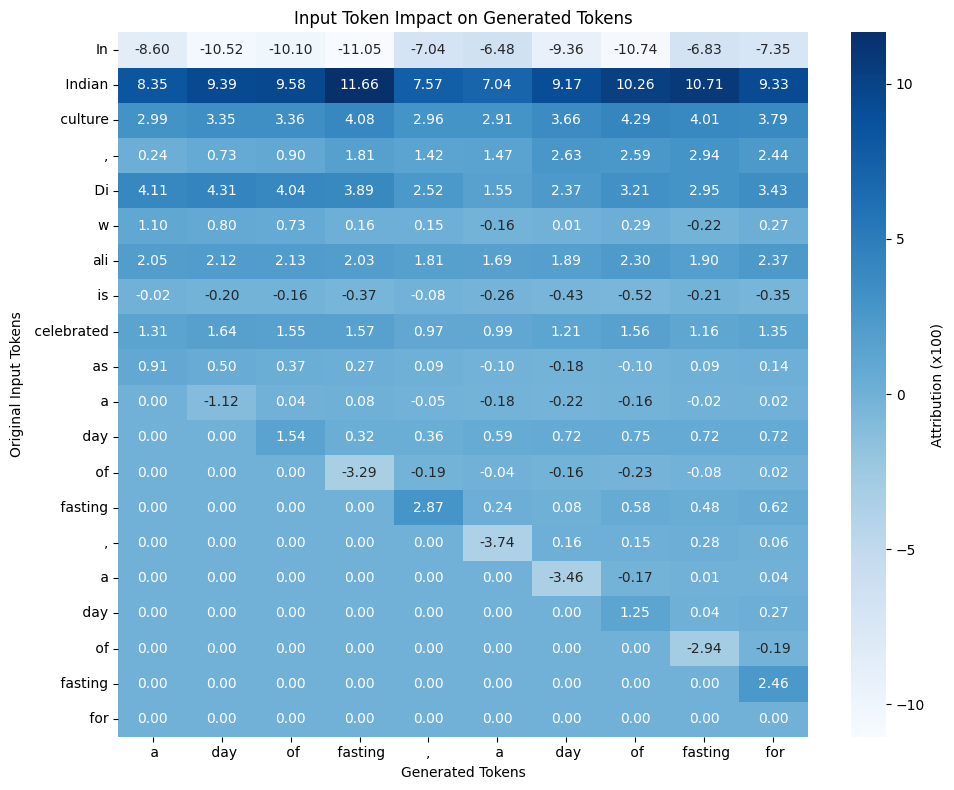

In [ ]:
generate_and_visualize_attributions(
    input_text="In Indian culture, Diwali is celebrated as",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
Imagine a world where gravity doesn’t exist. In this world, you can't go to the moon’ and you can't go to Mars’ and




100%|██████████| 20/20 [03:25<00:00, 10.30s/it]


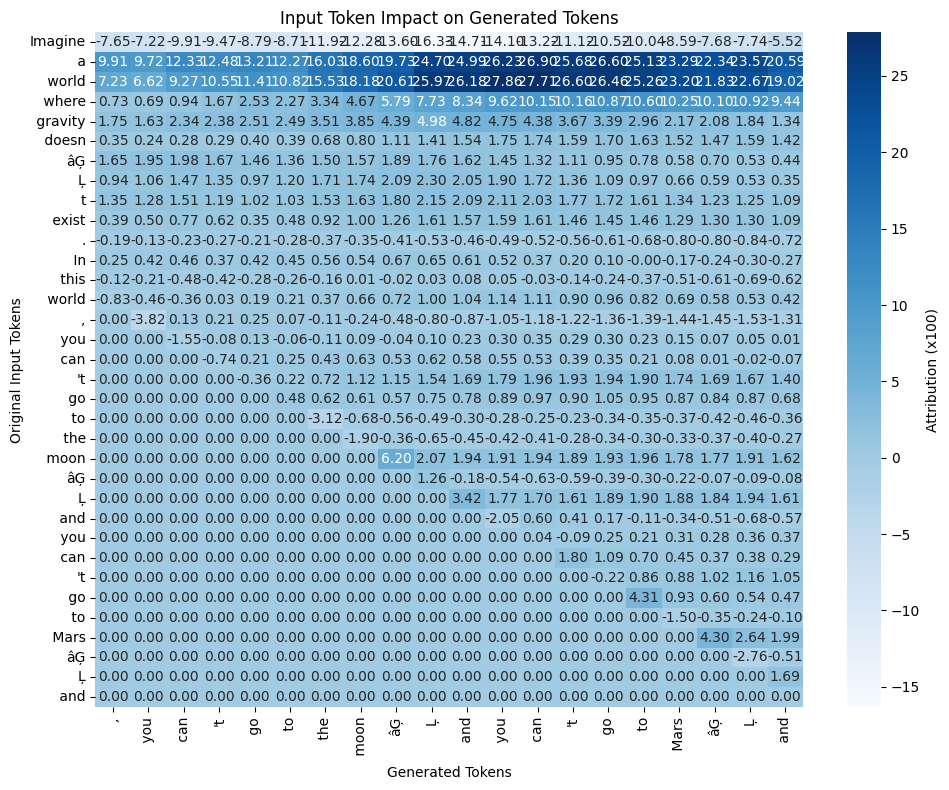

In [ ]:
generate_and_visualize_attributions(
    input_text="Imagine a world where gravity doesn’t exist. In this world",
    num_tokens_to_generate=20,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
Convert this number to Roman numerals: 2024, 2024, 2024, 2024, 2024, 2024




100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


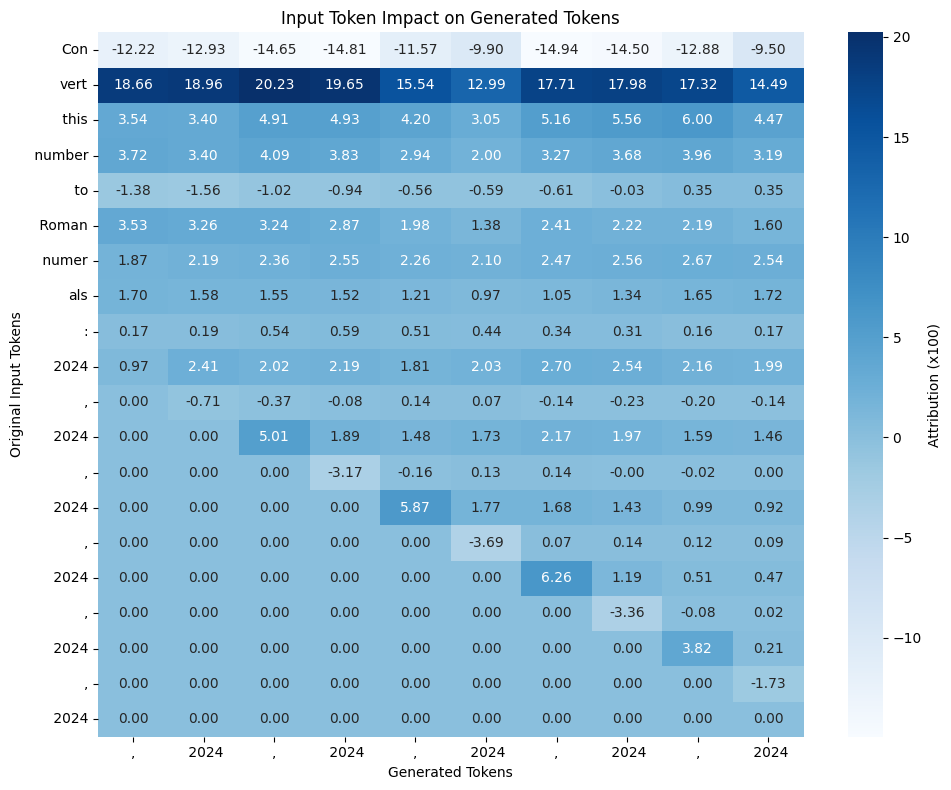

In [ ]:
generate_and_visualize_attributions(
    input_text="Convert this number to Roman numerals: 2024",
    num_tokens_to_generate=10,
    scale_factor=100,
    n_steps=50
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Full generated text:
I have three pets: a cat, a dog, and a parrot. The cat’s name is Luna, the dog’s name is Max, and the parrot’s name is Coco. The name of my dog is Luna.





100%|██████████| 3/3 [01:14<00:00, 24.89s/it]


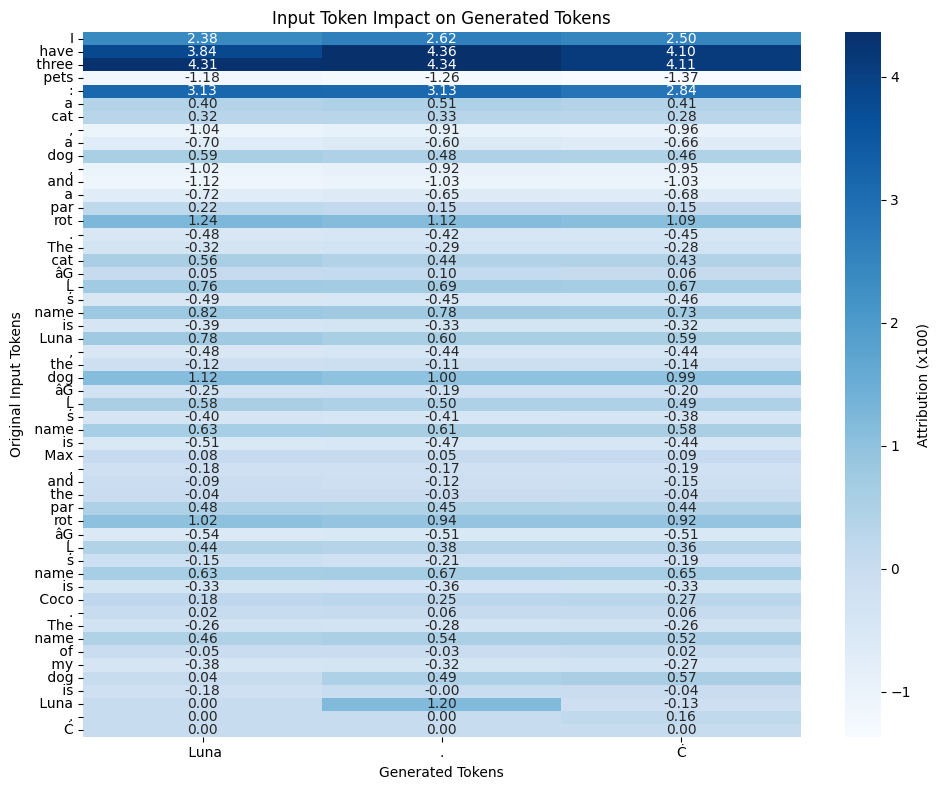

In [ ]:
generate_and_visualize_attributions(
    input_text="I have three pets: a cat, a dog, and a parrot. The cat’s name is Luna, the dog’s name is Max, and the parrot’s name is Coco. The name of my dog is",
    num_tokens_to_generate=3,
    scale_factor=100,
    n_steps=50
)